# Plots of scatter creation

In [15]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import clusterfit as cf
import os
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('nice.mplstyle')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# Load M21 data
obs_data = pd.read_csv('/cosma/home/do012/dc-he4/anisotropy-flamingo/data/obs/obs-properties.csv')
obs_data

,z,T(keV),Tmax,Tmin,Lx(1e44),eL(%),NHtot(1e20),Metal(solar),Met_max,Met_min,...,Y(nr/no_ksz),e_Y.2,Y(nr_mmf),e_Y.3,Y(nr_mf),e_Y.4,Abs_2MASS,BCG_Off.(/r500),Catalog,Analysed_by
0,0.2965,15.771000,16.169001,15.445000,20.510000,7.900000,6.44,0.378000,0.431000,0.336000,...,0.006365,0.000280,0.006300,0.000279,0.006838,0.000251,-27.302999,0.370,REFLEX,Chandra
1,0.0347,3.219000,3.271000,3.173000,3.030591,3.100000,30.50,0.385000,0.412000,0.361000,...,0.013039,0.001725,0.013064,0.001725,0.014058,0.001843,-25.742001,0.008,NORAS,Chandra
2,0.1073,4.674000,5.063000,4.353000,2.565000,9.100000,5.45,0.157000,0.293000,0.055000,...,0.003309,0.000446,0.003310,0.000446,0.003442,0.000421,-26.070000,0.028,NORAS,Chandra
3,0.0940,4.719000,4.915000,4.525000,1.245964,11.300000,2.13,0.332000,0.393000,0.261000,...,0.002611,0.000390,0.002617,0.000390,0.002600,0.000368,-1.000000,0.019,REFLEX,Chandra
4,0.0940,6.134000,6.782000,5.700000,1.427884,11.600000,4.46,0.624000,0.867000,0.373000,...,0.003937,0.000472,0.003937,0.000472,0.004137,0.000430,-27.004000,0.170,NORAS,Chandra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,0.0780,5.197000,6.510000,4.157700,1.087983,9.200000,4.40,0.497220,0.645514,0.361811,...,0.002750,0.000597,0.002749,0.000598,0.002787,0.000643,-26.302999,0.088,NORAS,XMM-Newton
309,0.0808,5.206686,5.774241,4.767557,1.114198,41.599998,4.60,0.779359,0.951330,0.607005,...,0.002983,0.000520,0.002981,0.000520,0.002813,0.000500,-25.764999,0.071,REFLEX,XMM-Newton
310,0.0554,1.309336,1.449910,1.192012,0.620700,26.600000,5.00,0.265811,0.280540,0.249088,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-24.851000,0.079,REFLEX,XMM-Newton
311,0.0661,3.613667,4.025164,3.221494,0.687003,36.000000,2.37,0.351152,0.422142,0.288451,...,0.001318,0.000391,0.001322,0.000390,0.001369,0.000365,-26.033001,0.127,REFLEX,XMM-Newton


In [17]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

# Fit a log-normal distribution for eL(%)
res_eL = stats.lognorm.fit(obs_data['eL(%)'])
reL = stats.lognorm.rvs(size=313, *res_eL, random_state=5)


# Compute eT based on your Tmax, Tmin, and T(keV)
maxT = obs_data['Tmax'].values
minT = obs_data['Tmin'].values
dT = obs_data['T(keV)'].values
eT = np.mean((np.abs(maxT - dT) / dT, np.abs(dT - minT) / dT), axis=0) * 100
eT = eT[eT < 40]

res_eT = stats.lognorm.fit(eT)
reT = stats.lognorm.rvs(size=313, *res_eT)


# For Ysz: fit a log taking account of eYsz
Y5r500 = obs_data['Y(r/no_ksz_arcmin^2)'].values
Yerr = obs_data['e_Y'].values
z = obs_data['z'].values

# SNR ratio selection to keep 260 objects
mask = (Y5r500 > 0) & (Y5r500/Yerr > 2)        

# Ysz
Y5r500 = Y5r500[mask]
Yerr = Yerr[mask]

# Percentage error for Ysz
eY = Yerr / Y5r500 * 100

res_eY = stats.lognorm.fit(eY)
reY = stats.lognorm.rvs(size=313, *res_eY)

# Use your function cf.Ysz(obs_data) for Ysz values
Ysz = cf.Ysz(obs_data)
log_Y = np.log10(Ysz)
log_eY = np.log10(eY)

# Fit log-log power law: log(eY) = log(A) + (1 - α) * log(Ysz)
slope, intercept, r_value, p_value, std_err = stats.linregress(log_Y, log_eY)

A_fit = 10**intercept
alpha_fit = slope

# Generate and plot simulated error
percentage_error = cf.eY(Ysz) * 100

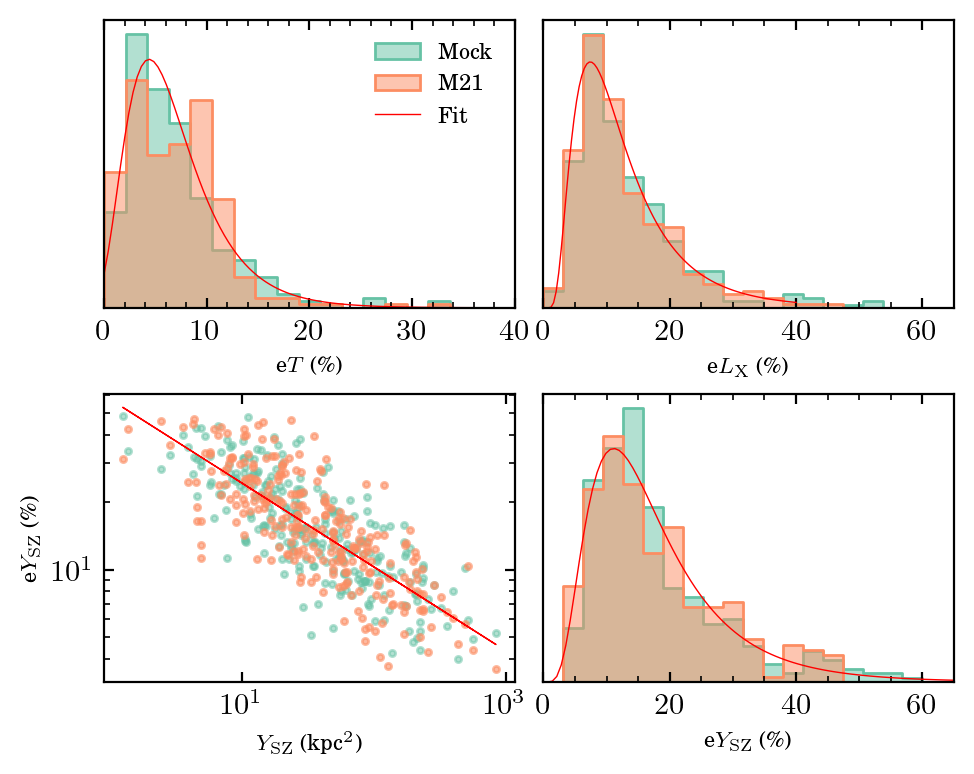

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 4), dpi=200)

labelfontsize=8
linewidth=0.5
colors = ['#fc8d62','#66c2a5','#8da0cb','#e78ac3','#a6d854']
bins_common = np.linspace(0, 60, 20)

# Plot histogram for eL(%)
sns.histplot(reL, stat='density', bins=bins_common, ax=axes[0, 1], label='Mock', color=colors[1], element='step', alpha=0.5)
sns.histplot(obs_data['eL(%)'], stat='density', bins=bins_common, ax=axes[0, 1], label='M21', color=colors[0], element='step', alpha=0.5)
X = np.linspace(0, 40, 100)
axes[0, 1].plot(X, stats.lognorm.pdf(X, *res_eL), color='r', label='Log-normal Fit', linewidth=linewidth)
axes[0, 1].set_ylabel('')
axes[0, 1].set_yticks([])
axes[0, 1].set_xlim(0, 65)
axes[0, 1].set_xlabel('e$L_\\mathrm{X}$ (\%)', fontsize=labelfontsize)
# axes[0, 1].legend(fontsize=8)

# Plot histogram for eT
sns.histplot(reT, stat='density', bins=np.linspace(0, 40, 20), ax=axes[0, 0], label='Mock', color=colors[1], element='step', alpha=0.5)
sns.histplot(eT, stat='density', bins=np.linspace(0, 40, 20), ax=axes[0, 0], label='M21', color=colors[0], element='step', alpha=0.5)
axes[0, 0].plot(X, stats.lognorm.pdf(X, *res_eT), color='r', label='Fit', linewidth=linewidth)
axes[0, 0].set_xlabel('e$T$ (\%)', fontsize=labelfontsize)
axes[0, 0].set_ylabel('')
axes[0, 0].set_yticks([])
axes[0, 0].set_xlim(0, 40)
axes[0, 0].legend(fontsize=8)

# Plot histogram for eY
sns.histplot(reY, stat='density', bins=bins_common, ax=axes[1, 1], label='Mock', color=colors[1], element='step', alpha=0.5)
sns.histplot(eY, stat='density', bins=bins_common, ax=axes[1, 1], label='M21', color=colors[0], element='step', alpha=0.5)
axes[1, 1].plot(np.linspace(0, 70, 100), stats.lognorm.pdf(np.linspace(0, 70, 100), *res_eY), color='r', label='Log-normal Fit', linewidth=linewidth)
axes[1, 1].set_xlabel('e$Y_\\mathrm{SZ}$ (\%)', fontsize=labelfontsize)
axes[1, 1].set_ylabel('')
axes[1, 1].set_yticks([])
axes[1, 1].set_xlim(0, 65)
# axes[1, 1].legend(fontsize=8)

# Plot scatter and power-law fit
axes[1, 0].scatter(Ysz, percentage_error, alpha=0.5, s=5, label='Mock', color=colors[1])
axes[1, 0].scatter(Ysz, eY, alpha=0.6, s=5, label='M21', color=colors[0])
axes[1, 0].plot(Ysz, A_fit * Ysz**alpha_fit, 'r', label='Power-law Fit', linewidth=linewidth)
axes[1, 0].set_xscale('log')
axes[1, 0].set_yscale('log')
axes[1, 0].set_xlabel('$Y_\\mathrm{SZ}$ (kpc$^2$)', fontsize=labelfontsize)
axes[1, 0].set_ylabel('e$Y_\\mathrm{SZ}$ (\%)', fontsize=labelfontsize)
# axes[1, 0].legend(fontsize=8)

plt.tight_layout()
fig.subplots_adjust(hspace=0.3, wspace=0.07)  # Adjust as needed

# plt.savefig('./to_paper/discussion_instrumental_uncertainties.png', bbox_inches='tight')
plt.show()